In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0   0.224973 -0.794358 -0.673224 -0.036918 -0.630480 -0.994056  0.103321   
  1  -0.754501  0.177964 -1.203486 -1.035737 -0.104757 -0.674179 -0.829904   
  2   0.453641 -0.331677  0.437486  0.391352 -1.252599 -0.641618 -0.444417   
  3  -0.332168 -0.180958 -0.447342  0.043410  0.324221  0.589155  0.376519   
  4  -0.689360 -0.196560  0.133789 -0.080730  0.226600  0.237378  0.553671   
  5  -0.724411 -0.613857  0.356394 -0.795982  0.118227 -1.123985  0.475505   
  6  -0.609367 -1.312012  0.905583 -0.310284 -0.560964  0.018120 -0.695530   
  7  -0.581325  0.638497  0.097292 -1.184359 -1.153033 -1.244556 -0.888005   
  8  -0.219280 -0.404631 -0.132664  0.103656  0.394635  0.307925  0.396563   
  9   0.304448 -0.390793 -0.162821 -0.320280  0.463797 -0.346520 -0.288374   
  10 -0.896473  0.216639  0.268334 -0.010421  0.133428 -0.601498 -0.566132   
  11 -0.553223  0.242450  0.614965 -0.360110  0.430476  0.202417 -0.550783   
  12 -0.373970 -0.306527 -0.481670 -1.458304  0.034174  0.394811  0.970199   
  13  0.770275  0.644710  0.724867  0.176097  0.046500  0.201510 -0.012503   
  14 -0.580271  0.150977  0.211038 -0.340733  0.091139  0.052293 -0.292815   
  15 -0.571439  0.638738  0.439052 -0.330537  0.236323 -0.865272 -1.015359   
  16 -0.626232  0.038321 -0.219582 -0.439641  0.561133 -0.756800  0.390243   
  17 -0.611648 -0.507484  0.769941  0.150489 -0.296112  0.164208 -0.288748   
  18 -0.451410  0.000259  1.276118 -0.092820  0.279312 -0.814243 -0.670224   
  19 -0.191255  0.262368  0.744360  0.057503 -0.829612 -2.101938  0.572931   
  20 -0.164383 -0.694962 -0.605063 -0.888348  0.297720  0.546565 -0.943518   
  21  0.168855  0.325081 -0.008122 -0.822221  0.082179 -1.122305 -1.280704   
  22 -0.345892 -0.524848  0.142135  0.291096  0.397389 -0.071873  0.529082   
  23 -0.183817 -0.679869 -1.142404 -0.219347  0.586963  0.090899  0.672358   
  24  0.470251 -0.268491 -0.680529 -0.502458 -1.104085 -0.557983  0.283684   
1 0   0.247250  0.306039  0.152182  0.728537 -0.174921  0.607230 -0.127793   
  1  -1.001213 -0.429103 -0.444285  0.154927  0.125112  0.214170 -0.439817   
  2   0.325660  0.589398  1.090581  0.684259 -0.145063  0.096549 -0.912813   
  3   0.322778 -0.361944 -0.129865  0.493326  0.234689  0.675220 -0.232858   
  4  -0.125835 -0.134926  0.223783  0.208111  0.614763  0.116263 -0.131723   

            X8        X9       X10  ...       X94       X95       X96  \
0 0  -0.426540  0.075113  0.086754  ... -0.166240  0.129954 -0.118287   
  1  -0.087229 -0.880483 -0.113360  ...  0.134924 -0.990929 -0.176342   
  2   0.307592 -0.867210  0.230911  ...  0.391188  0.247967  0.449437   
  3   0.518337 -0.199072  0.482685  ...  0.584143  0.257472  0.482308   
  4  -0.351894  0.586115  0.958694  ... -1.357810  0.494924  0.157514   
  5  -0.023337 -0.246563  1.036557  ...  0.236664 -0.599131  0.281322   
  6  -0.376091 -1.366179  0.606028  ...  0.153433  0.203506  0.793542   
  7  -1.796534  0.026998  0.856517  ...  0.102869 -0.883701  0.553858   
  8  -0.789794  0.137271  0.113944  ...  0.603090  0.173211 -0.306438   
  9  -0.496674 -0.817502 -0.447100  ... -1.127466 -0.773222 -0.044650   
  10 -0.604713  0.369320  0.128658  ...  0.263634  0.332259  0.337084   
  11 -0.697706  0.194106 -0.217266  ... -0.051280 -0.386589  0.490645   
  12 -0.782048 -0.267289  0.670187  ... -0.226094 -0.004684  0.284401   
  13 -0.051102 -0.808661  0.145849  ... -0.216721 -0.474176 -0.148183   
  14 -1.253717 -0.322479 -0.469889  ... -0.739017 -1.472909 -0.258612   
  15 -1.528563 -0.676592  0.163943  ...  0.023159 -0.128010  0.631625   
  16 -0.908153 -1.665508 -0.447479  ... -0.383778 -1.028492  0.744732   
  17 -0.194590 -1.328734 -0.431188  ... -0.882636 -0.300772  0.873579   
  18 -0.057641 -0.876973 -0.581929  ...  0.792491  0.064042 -0.357051   
  19  0.259134 -0.668063  0.111767  ...  0.254124  0.955138  0.838103   
  20 -0.459678 -0.514493 -0.036288  ... -0.940994  0.252401 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err          t          P>|t|     2.5 %    97.5 %
D  0.985784  0.042292  23.309004  3.592773e-120  0.902893  1.068675


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



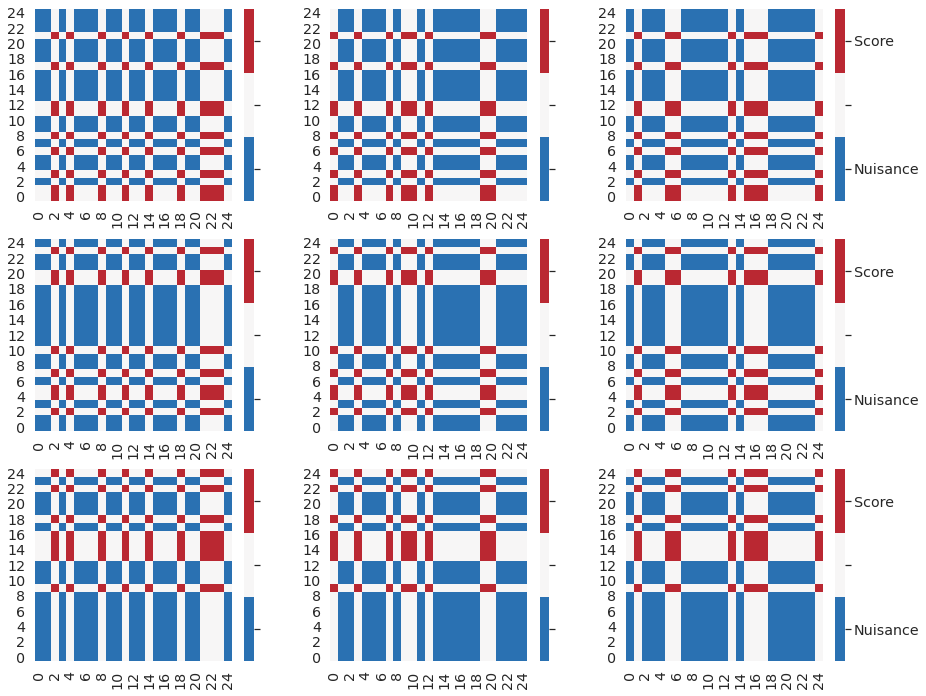

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



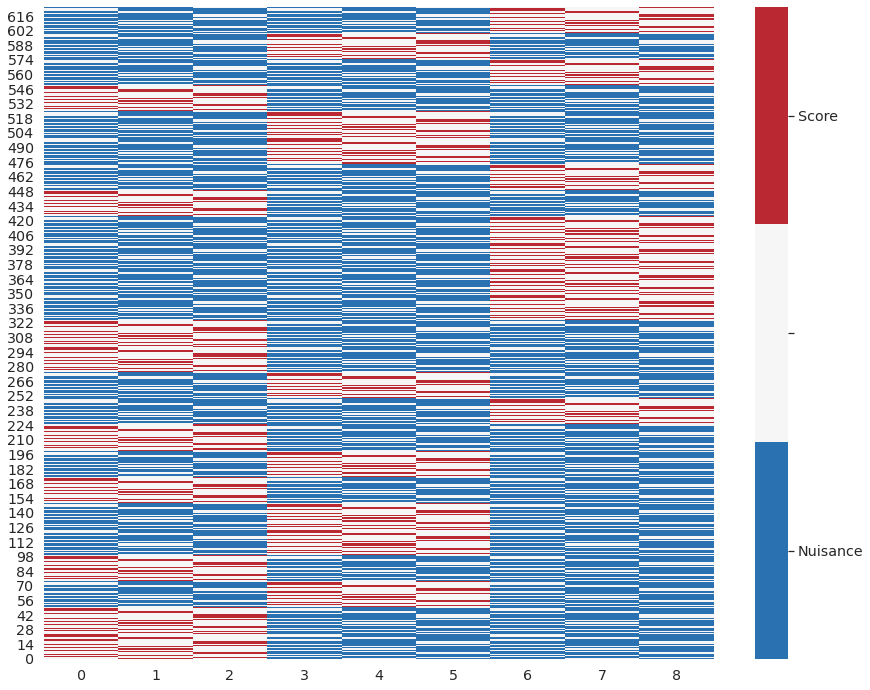

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])